## Maps of ocean surface DMS concentration 
- Global maps of the DMS concentration (mol/m3) at the ocean surface annually averaged for the historical experiment from CNRMESM2-1 and UKESM1-0 for different ensembles
- Green land area of the same thing as above
- Later on, maybe, a contrasting area in Siberia

In [98]:
# load useful packages
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy 
import cartopy.crs as ccrs
import functions
import s3fs
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib as mpl
%matplotlib inline

### open CMIP6 online catalog from pangeo
### Load data from CMIP6 of DMS from ocean for fully coupled model simulations (ocean + atmosphere). Historical experiment.

In [2]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(variable_id=['dmso'],experiment_id=['historical'])
#cat = col.search(variable_id=['emidms'])
cat.df

activity_id institution_id    source_id experiment_id member_id table_id  \
0        CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical  r1i1p1f2     Omon   

  variable_id grid_label                                             zstore  \
0        dmso         gn  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...   

   dcpp_init_year   version  
0             NaN  20181206

### After what we found on pangeo, we load DMS data from CNRM_ESM2-1 (only one available), historical experiment. 
Note: It would be ideal to find more ensembles to average over them.

In [3]:
cat = col.search(variable_id=['dmso'],source_id=['CNRM-ESM2-1'],
 activity_id = ['CMIP'], experiment_id=['historical'], table_id=['Omon'], 
                  member_id=['r1i1p1f2']
                )
cat.df

activity_id institution_id    source_id experiment_id member_id table_id  \
0        CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical  r1i1p1f2     Omon   

  variable_id grid_label                                             zstore  \
0        dmso         gn  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...   

   dcpp_init_year   version  
0             NaN  20181206

In [4]:
### data from CMIP6 of DMS for OMIP model simulations, where the atmosphere is prescribed. These data are in a bucket and not in pangeo
dset_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})
list(dset_dict.keys())


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn']

### since our focus is only on the surface DMS concentration and the here dmso is over all levels, we choose only the surface one and ignore the rest.

In [5]:
dset = dset_dict['CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn']
dset = dset.isel(lev=0).squeeze()
dset
## checking the metadata
print(dset['dmso'])

<xarray.DataArray 'dmso' (time: 1980, y: 294, x: 362)>
dask.array<getitem, shape=(1980, 294, 362), dtype=float32, chunksize=(4, 294, 362), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lev        float64 0.5058
    lon        (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    cell_measures:       area: areacello volume: volcello
    cell_methods:        area: mean where sea time: mean
    description:         Mole Concentration of Dimethyl Sulphide in sea water
    history:             none
    interval_operation:  1800 s
    interval_write:      1 month
    long_name:           Mole Concentration of Dimethyl Sulphide in sea water
    online_operation:    average
    standard_name:       mole_concentration_of_dimethyl_sulfide_in_sea_water
    u

### selecting the area using "where" function and plotting it

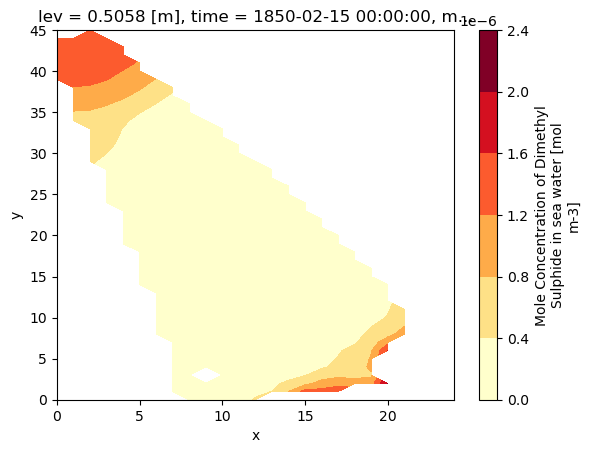

In [6]:
## Greenland
dmsset_GLarea = dset.where((dset.lon>=-10) & (dset.lon<=10) 
                           & (dset.lat <= 85)  & (dset.lat >= 60),
                         drop=True).compute()
## test plotting one time from the data array
dmsset_GLarea['dmso'].sel(time=cftime.DatetimeGregorian
                          (1850, 2, 15, 0, 0, 0, has_year_zero=False)).plot.contourf(cmap='YlOrRd')

In [7]:
dmsset_GLarea

<xarray.Dataset>
Dimensions:      (time: 1980, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon   (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 52.85 52.1
    lat          (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 -18.25 -17.08 -15.91 ... 49.82 50.68 51.49
  * time         (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 1850-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

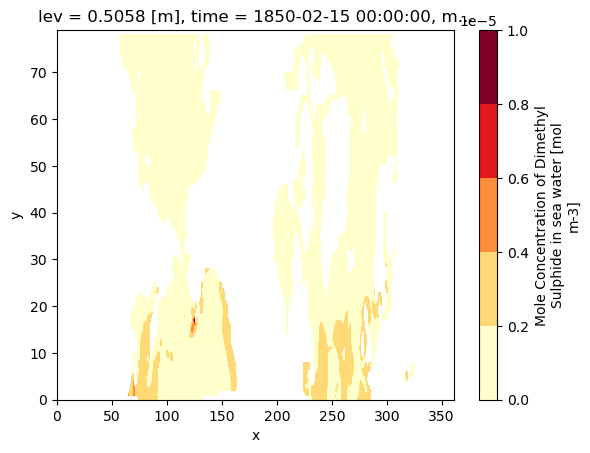

In [8]:
## Arctic
dmsset_ARCarea = dset.where((dset.lon>=-180) 
                       & (dset.lon<=180) 
                       & (dset.lat <= 90)  
                       & (dset.lat >= 45),
                         drop=True).compute()
## test plotting one time in the data array
dmsset_ARCarea['dmso'].sel(time=cftime.DatetimeGregorian
                          (1850, 2, 15, 0, 0, 0, has_year_zero=False)).plot.contourf(cmap='YlOrRd')
#dset_ARCarea['dmso']

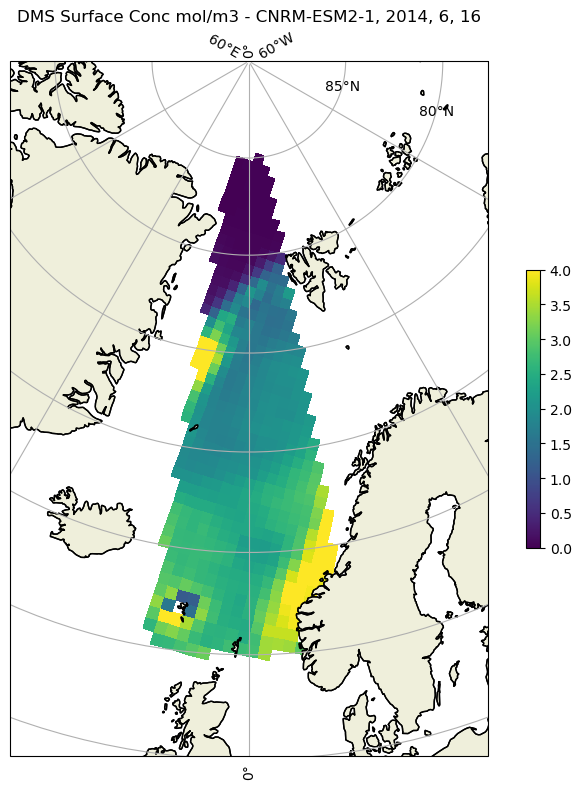

In [9]:
import cartopy
fig, ax = plt.subplots(figsize=(8,8),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())
#pl_CMIP6


pl=ax.pcolormesh(dmsset_GLarea.lon, dmsset_GLarea.lat,
              1.0e6*dmsset_GLarea['dmso'].sel(
    time=(cftime.DatetimeGregorian(2014, 6, 16, 0, 0, 0, 0, has_year_zero=False)) ), 
    vmin=0,vmax=4,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, 2014, 6, 16')
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.colorbar(pl,shrink=0.4)
fig.tight_layout()

### calculating the annual mean and its STD of DMS surface concentration for the whole historical period from 1850 to 2014

In [10]:
dms_AnnMean_AllHistrorical_GL = dmsset_GLarea.mean(dim='time').compute() #.compute does the excution of the mean operation
dms_AnnMean_AllHistrorical_GL

<xarray.Dataset>
Dimensions:     (y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

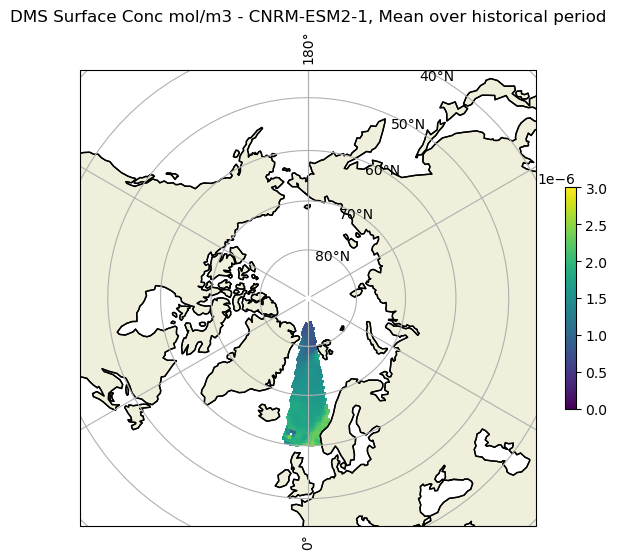

In [11]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180,45,90], ccrs.PlateCarree())



pl_CMIP6=ax.pcolormesh(dms_AnnMean_AllHistrorical_GL.lon, dms_AnnMean_AllHistrorical_GL.lat,
              dms_AnnMean_AllHistrorical_GL['dmso'], 
    vmin=0,vmax=3.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over historical period')
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()

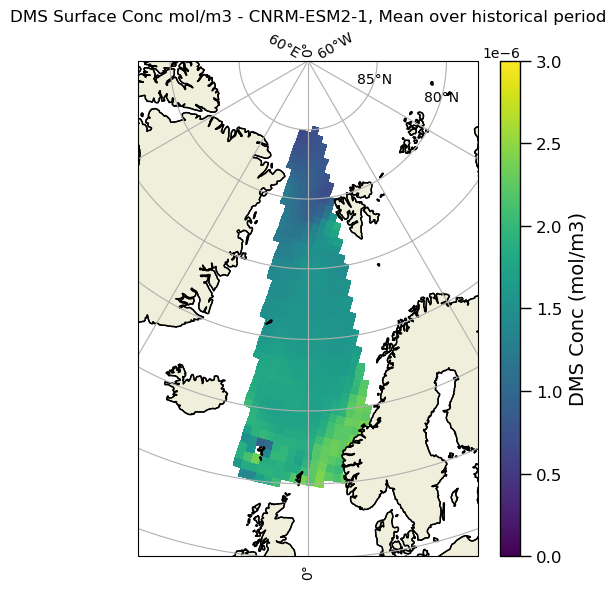

In [12]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())



pl_CMIP6=ax.pcolormesh(dms_AnnMean_AllHistrorical_GL.lon, dms_AnnMean_AllHistrorical_GL.lat,
              dms_AnnMean_AllHistrorical_GL['dmso'], 
    vmin=0,vmax=3.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over historical period')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc (mol/m3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)

In [13]:
dmsset_seasonal_AnnMean_AllHistrorical_GL = dmsset_GLarea.groupby('time.season').mean('time').compute()
dmsset_seasonal_AnnMean_AllHistrorical_GL

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.Dataset>
Dimensions:     (season: 4, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    lev_bounds  (axis_nbounds) float64 0.0 1.024
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (season, y, x) float32 nan nan nan nan nan ... nan nan nan nan

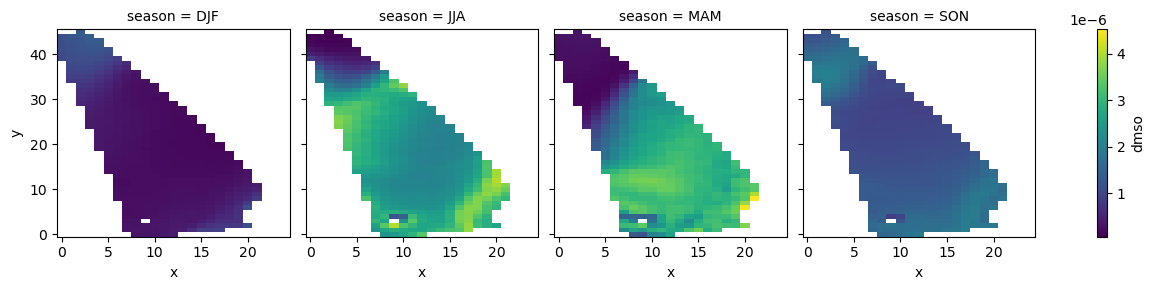

In [14]:
dmsset_seasonal_AnnMean_AllHistrorical_GL['dmso'].plot(col='season')

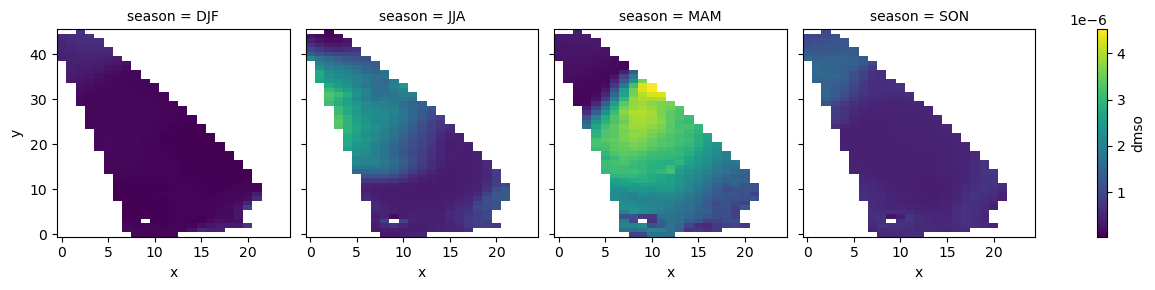

In [15]:
dmsset_seasonal_AnnSTD_AllHistrorical_GL = dmsset_GLarea.groupby('time.season').std('time').compute()
dmsset_seasonal_AnnSTD_AllHistrorical_GL
dmsset_seasonal_AnnSTD_AllHistrorical_GL['dmso'].plot(col='season')

In [16]:
## focusing on the period 2003 to 2014 that match observation  fro MODIS-Aqua
dms_2003to2014_GL = dmsset_GLarea.isel(time = slice(1836,None)).compute() #.compute does the excution of the mean operation
dms_2003to2014_GL

<xarray.Dataset>
Dimensions:      (time: 144, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon   (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 52.85 52.1
    lat          (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 -18.25 -17.08 -15.91 ... 49.82 50.68 51.49
  * time         (time) object 2003-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 2003-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

In [17]:
dms_AnnMean_2003to2014_GL = dms_2003to2014_GL.mean(dim='time').compute() 
#.compute does the excution of the mean operation
dms_AnnMean_2003to2014_GL

<xarray.Dataset>
Dimensions:     (y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

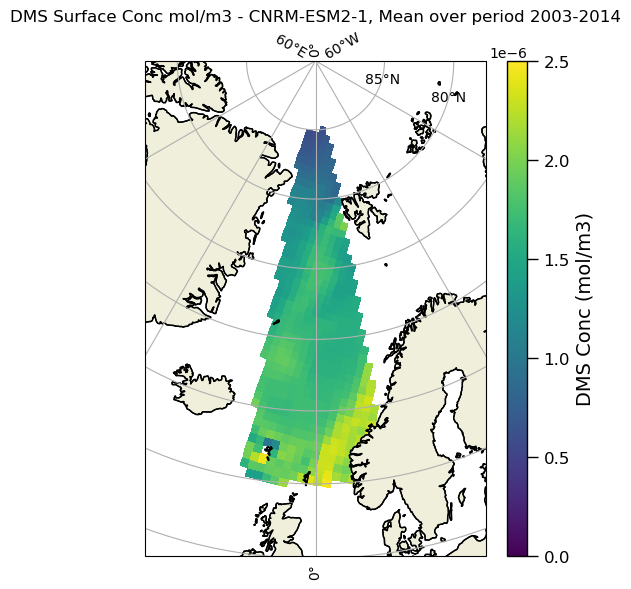

In [18]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())



pl_CMIP6=ax.pcolormesh(dms_AnnMean_2003to2014_GL.lon, dms_AnnMean_2003to2014_GL.lat,
              dms_AnnMean_2003to2014_GL['dmso'], 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over period 2003-2014')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc (mol/m3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('DMS_SurfConc_CNRM-ESM-1_Greenland_Avrg2003to2014.png')

In [19]:
## checking the max
np.max(dms_AnnMean_2003to2014_GL['dmso'])


<xarray.DataArray 'dmso' ()>
array(2.45889055e-06)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'

In [20]:
## focusing on the period 2003 to 2014 that match observation from MODIS-Aqua
dms_2003to2014_ARCT = dmsset_ARCarea.isel(time = slice(1836,None)
                                         ).compute() 
#.compute does the excution of the mean operation
dms_2003to2014_ARCT

<xarray.Dataset>
Dimensions:      (time: 144, y: 80, x: 362, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 40.93 40.93 41.32 ... 50.11 50.11 49.98
    bounds_lon   (y, x, nvertex) float64 72.02 73.0 73.0 ... 73.0 72.95 73.0
    lat          (y, x) float64 41.13 41.13 41.13 41.13 ... 50.23 50.01 50.01
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 72.51 73.49 74.47 75.45 ... 73.04 73.0 72.99
  * time         (time) object 2003-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 2003-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

In [21]:
## save the data-array as netcdf file
dms_2003to2014_ARCT.to_netcdf('dms_2003to2014_ARCT.nc')

In [22]:
dms_AnnMean_2003to2014_ARCT = dms_2003to2014_ARCT.mean(dim='time').compute() 
#.compute does the excution of the mean operation
dms_AnnMean_2003to2014_ARCT

<xarray.Dataset>
Dimensions:     (y: 80, x: 362, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 40.93 40.93 41.32 ... 50.11 50.11 49.98
    bounds_lon  (y, x, nvertex) float64 72.02 73.0 73.0 ... 73.0 72.95 73.0
    lat         (y, x) float64 41.13 41.13 41.13 41.13 ... 50.23 50.01 50.01
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 72.51 73.49 74.47 75.45 ... 73.04 73.0 72.99
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

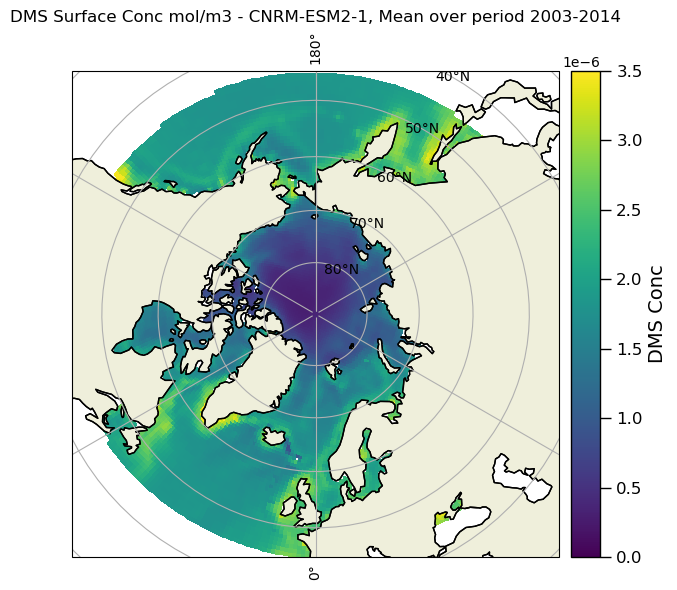

In [23]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-180, 180,45,90], ccrs.PlateCarree())

pl_CMIP6=ax.pcolormesh(dms_AnnMean_2003to2014_ARCT.lon, dms_AnnMean_2003to2014_ARCT.lat,
              dms_AnnMean_2003to2014_ARCT['dmso'],
    vmin=0,vmax=3.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over period 2003-2014')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)

## DMS conc comparison between CNRM(model) and observation for GL
#### choose the overlapping periods. 
#### For observations, we have the DMS concentration from two satallites (Gali et al PNAS 2019, and supplementary material)
- A from MODIS-Aqua data covered the period 2003-2016 five years overlapping 2003-2007
- S from SeaWiFS data covered the period 1998-2007

In [24]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
s3.ls('escience2022/Antoine/Satellite_Arctic_DMS')

['escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2003_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2004_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2005_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2006_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2007_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2008_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2009_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2011_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2012_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2013_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2014_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2015_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2016_8D_28km.nc',
 'esci

In [25]:
s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
remote_files = s3.glob(s3files)
fileset = [s3.open(file) for file in remote_files]
ds_obs = xr.open_mfdataset(fileset, combine='by_coords')

ds_obs

<xarray.Dataset>
Dimensions:      (year: 14, pixel: 96668, period: 46)
Coordinates:
  * year         (year) float64 2.003e+03 2.004e+03 ... 2.015e+03 2.016e+03
Dimensions without coordinates: pixel, period
Data variables:
    longitude    (year, pixel) float64 dask.array<chunksize=(1, 96668), meta=np.ndarray>
    latitude     (year, pixel) float64 dask.array<chunksize=(1, 96668), meta=np.ndarray>
    startjulday  (year, period) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    endjulday    (year, period) float64 dask.array<chunksize=(1, 46), meta=np.ndarray>
    dms          (period, year, pixel) float64 dask.array<chunksize=(46, 1, 96668), meta=np.ndarray>

In [26]:
## add date
import datetime
dates = np.array([
    [datetime.datetime(int(y.values), 1, 1) + datetime.timedelta(d.values - 1) for d in ds_obs.startjulday.sel(year=y)] 
        for y in ds_obs.year])

ds_obs=ds_obs.assign_coords({ "d": (['year','period'],dates ) })
ds_obs=ds_obs.stack(time=['year','period'])
ds_obs=ds_obs.set_index(time='d')
ds_obs

<xarray.Dataset>
Dimensions:      (pixel: 96668, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>
    latitude     (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>
    startjulday  (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    endjulday    (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>

### choose the same area as in CNRM

In [27]:
## Greenland
DmsObs_GLarea = ds_obs.where((ds_obs.longitude>=-10) & (ds_obs.longitude<=10) 
                           & (ds_obs.latitude <= 85)  & (ds_obs.latitude >= 60),
                         drop=True).compute()
DmsObs_GLarea

<xarray.Dataset>
Dimensions:      (pixel: 2386, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.54 -9.54 -9.54 ... 8.372 8.372 8.372
    latitude     (pixel, time) float64 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan ... nan nan nan nan

In [28]:
## we select the period from 2003 to 2014 and ignore the the last two years
dmsObs_2003to2014_GL = DmsObs_GLarea.isel(time= slice(552))
dmsObs_2003to2014_GL

<xarray.Dataset>
Dimensions:      (pixel: 2386, time: 552)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year         (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.54 -9.54 -9.54 ... 8.372 8.372 8.372
    latitude     (pixel, time) float64 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan ... nan nan nan nan

In [29]:
dmsObs_AnnMean_2003to2014_GL = dmsObs_2003to2014_GL.mean(dim='time').compute() 
#.compute does the excution of the mean operation
dmsObs_AnnMean_2003to2014_GL


<xarray.Dataset>
Dimensions:      (pixel: 2386)
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 -9.54 -9.038 -8.536 ... 2.791 5.581 8.372
    latitude     (pixel) float64 60.12 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (pixel) float64 181.0 181.0 181.0 181.0 ... 181.0 181.0 181.0
    endjulday    (pixel) float64 187.9 187.9 187.9 187.9 ... 187.9 187.9 187.9
    dms          (pixel) float64 3.503 3.463 3.421 3.479 ... nan nan nan nan

##### Note: The coordinates system of these observations are indexed with pixels instead of (x,y) or (i,j) system. Therefore, we use this function to fix that and make the dmsos from observations comparable with CMIP6 modeling data  

In [30]:
from scipy.interpolate import griddata

def interGali(ds,var):
    '''
        Interploting data on a regular lat,lon grid
        grid is built from latitudes and the longitudes on the lowest latitude
        Input : 
            ds : xarray dataset with latitude, longitude and variable "var" to be interpolated. 
                var, lat,long must be 1d (ie. not depend on time)
            var : string name of variable
        Returns a xarray dataArray with the gridded variable and lat lon as coords
    '''
    
    # sorting according to latitudes
    lalo = pd.MultiIndex.from_arrays([ds.latitude.values, ds.longitude.values]).sortlevel(level=0)[0] 
    # get longitudes of lowest latitude
    lowlat = lalo.values[0][0]
    lon1d = np.array([x[1] for x in lalo.values if x[0]==lowlat])
    # get latitudes
    lat1d = np.unique(ds.latitude.values)
    # Building regular grid of lat and lon
    lon, lat = np.meshgrid(lon1d,lat1d)

    # interpolation
    var_gridded =griddata(
            (ds.longitude.values, ds.latitude.values), #points
            ds[var].values, #data
            (lon, lat), #grid on which to interpolate
            method='nearest')
    
    return  xr.DataArray(
        var_gridded,
        dims=("lat","lon"),
        coords={
            "lat": lat1d,
            "lon": lon1d
        }
    )
    

In [31]:
#dms_gridded_obs_test = interGali(ds_obs, 'dms')
#
dmsObs_AnnMean_2003to2014_GL = interGali(dmsObs_AnnMean_2003to2014_GL, 'dms')
dmsObs_AnnMean_2003to2014_GL

<xarray.DataArray (lat: 100, lon: 39)>
array([[3.50323675, 3.46251406, 3.42095896, ...,        nan,        nan,
               nan],
       [3.28994455, 3.37295222, 3.46074923, ...,        nan,        nan,
               nan],
       [3.22220966, 3.32487218, 3.45579508, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float64 60.12 60.38 60.62 60.88 ... 84.12 84.38 84.62 84.88
  * lon      (lon) float64 -9.54 -9.038 -8.536 -8.033 ... 8.033 8.536 9.038 9.54

In [32]:
### siberia
#lon[100,160]
#lat[70,80]

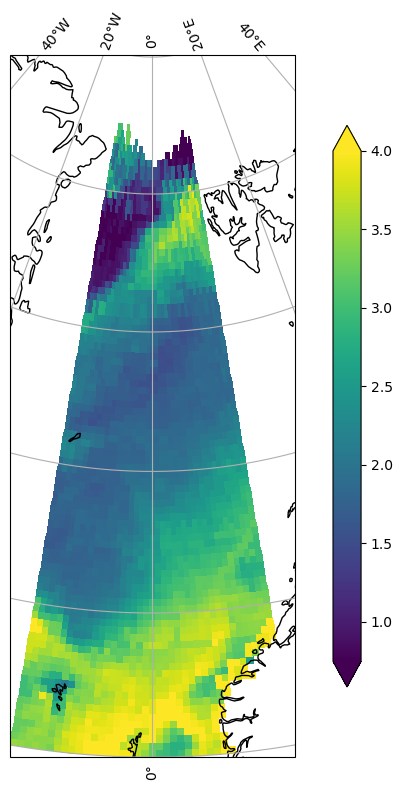

In [33]:
fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()}
                       # subplot_kw={'projection':ccrs.PlateCarree()
                                  )

dmsObs_AnnMean_2003to2014_GL.plot.pcolormesh( 
    ax = ax,
    cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
    transform=ccrs.PlateCarree(),
    robust=True
)


ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()

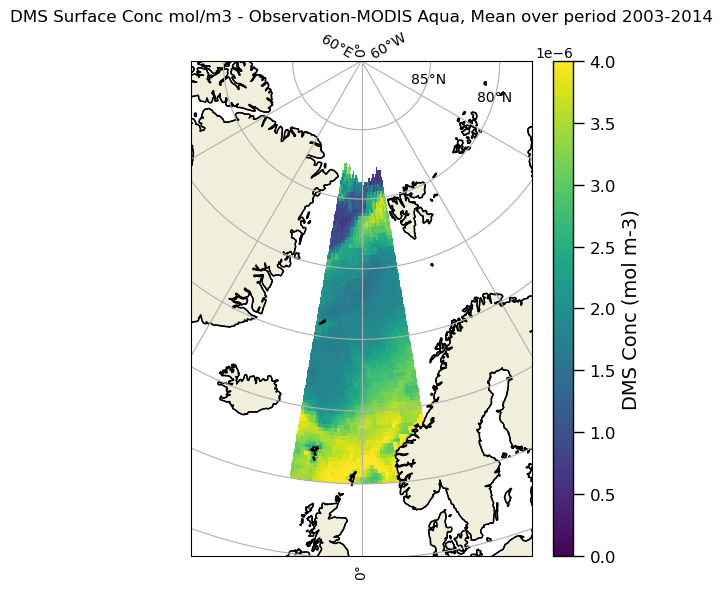

In [34]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())

pl_CMIP6=ax.pcolormesh(dmsObs_AnnMean_2003to2014_GL.lon, dmsObs_AnnMean_2003to2014_GL.lat,
              dmsObs_AnnMean_2003to2014_GL*1.0e-6,
    vmin=0,vmax=4e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )

ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - Observation-MODIS Aqua, Mean over period 2003-2014')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc (mol m-3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('DMS_SurfConc_Obs_ModisAqua_Greenland_Avrg2003to2014.png')

## Global mean of ocean surface DMS concentration over GL

#### get the areacello for CNRM-ESM1-2

In [35]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['CNRM-ESM2-1'], activity_id = ['CMIP']
                 , experiment_id=['historical'], table_id=['Ofx']
                 , variable_id=['areacello']
                 , member_id=['r1i1p1f2']
                )
cat.df

activity_id institution_id    source_id experiment_id member_id table_id  \
0        CMIP   CNRM-CERFACS  CNRM-ESM2-1    historical  r1i1p1f2      Ofx   

  variable_id grid_label                                             zstore  \
0   areacello         gn  gs://cmip6/CMIP6/CMIP/CNRM-CERFACS/CNRM-ESM2-1...   

   dcpp_init_year   version  
0             NaN  20181206

In [36]:
GlbArea_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [37]:
areacello = GlbArea_dict[list(GlbArea_dict.keys())[0]]
areacello = areacello.squeeze()
areacello

<xarray.Dataset>
Dimensions:     (y: 294, x: 362, nvertex: 4)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    bounds_lon  (y, x, nvertex) float64 dask.array<chunksize=(294, 362, 4), meta=np.ndarray>
    lat         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    lon         (y, x) float64 dask.array<chunksize=(294, 362), meta=np.ndarray>
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex
Data variables:
    areacello   (y, x) float32 dask.array<chunksize=(294, 362), meta=np.ndarray>
Attributes: (12/56)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    xios_commit:             1442-shuffle
    status:                  2019-10-25;created;by nhn2@columbia.edu
    netcdf_tracking_ids:     hdl:21.14100/4e2f1651-782d-48b3-ba43-287dd16d7fe8
    version_id:              v20181206
    intake_esm_varname:      ['areacello']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Ofx.gn

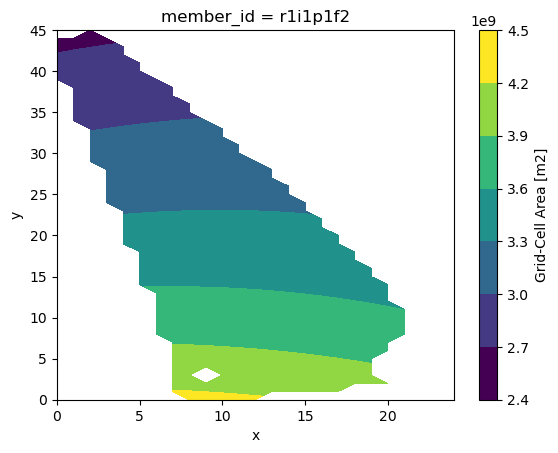

In [38]:
GLarea = areacello.areacello.where((areacello.lat>=60) 
                                   & (areacello.lat<=85) 
                                   & (areacello.lon <= 10)  
                                   & (areacello.lon >= -10),
                                  drop=True)
GLarea.plot.contourf()

In [39]:
GLarea

<xarray.DataArray 'areacello' (y: 46, x: 25)>
dask.array<where, shape=(46, 25), dtype=float32, chunksize=(46, 25), chunktype=numpy.ndarray>
Coordinates:
    lat        (y, x) float64 dask.array<chunksize=(46, 25), meta=np.ndarray>
    lon        (y, x) float64 dask.array<chunksize=(46, 25), meta=np.ndarray>
    member_id  <U8 'r1i1p1f2'
Dimensions without coordinates: y, x
Attributes:
    cell_methods:      area: sum
    description:       Cell areas for any grid used to report ocean variables...
    history:           none
    long_name:         Grid-Cell Area
    online_operation:  once
    standard_name:     cell_area
    units:             m2

In [40]:
dms_AnnMean_AllHistrorical_GL

<xarray.Dataset>
Dimensions:     (y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat  (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon  (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 50.91 52.85 52.1
    lat         (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev         float64 0.5058
    lev_bounds  (axis_nbounds) float64 0.0 1.024
    lon         (y, x) float64 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49
    member_id   <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [41]:
## averaging over the whole area of GL
dmsset_AreaMean_GL = (GLarea*dmsset_GLarea['dmso']
                               ).sum(dim=('x','y'))/GLarea.sum(dim=('x','y')
                              ,keep_attrs=True)
dmsset_AreaMean_GL

<xarray.DataArray (time: 1980)>
dask.array<truediv, shape=(1980,), dtype=float32, chunksize=(1980,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00

<xarray.DataArray (time: 165)>
dask.array<getitem, shape=(165,), dtype=float32, chunksize=(165,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00

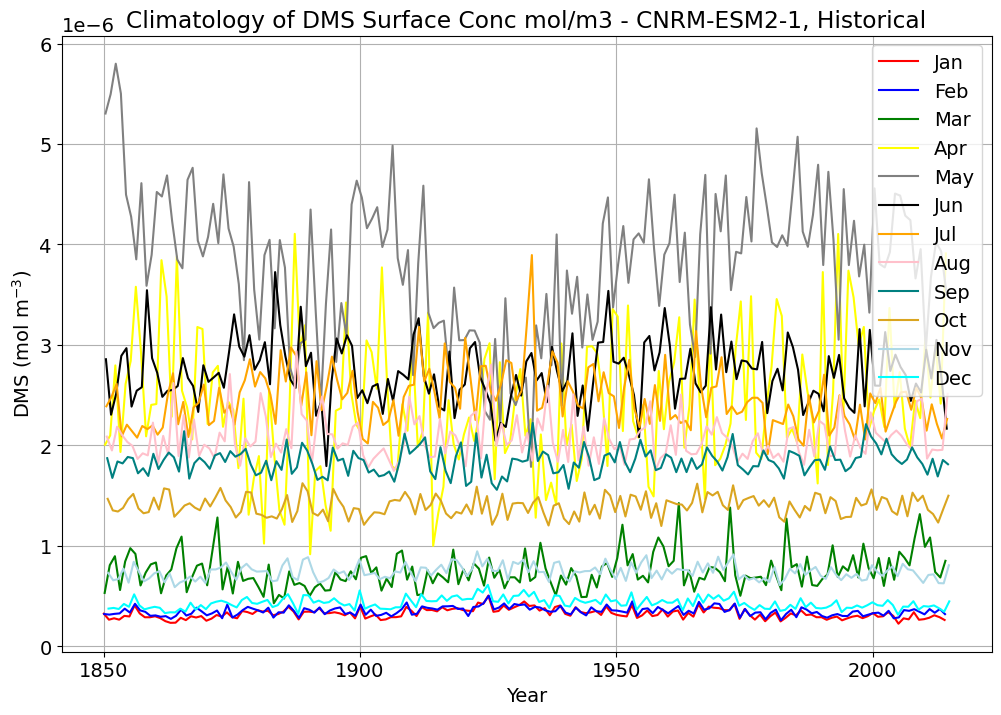

In [179]:
mpl.rcParams.update({'font.size':14})
fig, ax = plt.subplots(1,figsize=(12,8))
colors=['red','blue','green','yellow','gray','black','orange','pink','teal',
        'goldenrod','lightblue','cyan']
month_list=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
for i in range(0,12):
    GL_month_dmsset_AreaMean_allmonth=dmsset_AreaMean_GL[i::12]
    plt_avrg=plt.plot(GL_month_dmsset_AreaMean_allmonth.time,GL_month_dmsset_AreaMean_allmonth, 
                      color=colors[i],label=month_list[i])

#plt.plot(dmsset_AreaMean_GL.time,dmsset_AreaMean_GL, color='gray')
plt.legend()
plt.xlabel('Year')
plt.ylabel('DMS (mol m$^{-3}$)')
plt.title('Climatology of DMS Surface Conc mol/m3 - CNRM-ESM2-1, Historical')
plt.savefig('climatology_variability_of_DMS_SurfConc_GLarea_CNRM.png')
plt.grid()
GL_month_dmsset_AreaMean_allmonth

<xarray.DataArray (time: 165)>
dask.array<getitem, shape=(165,), dtype=float32, chunksize=(165,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1850-12-16 12:00:00 ... 2014-12-16 12:00:00

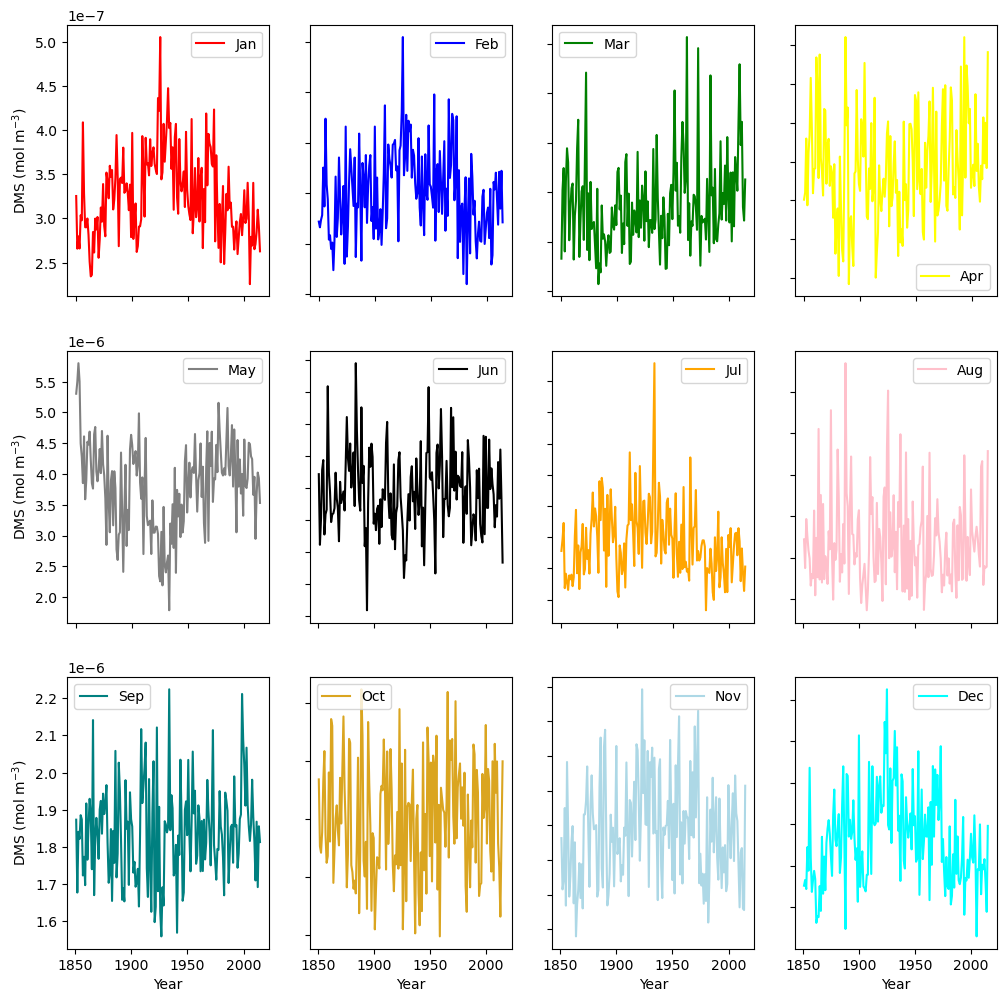

In [43]:
#xr.plot(GL_month_dmsset_AreaMean_April)
fig = plt.figure(figsize=(12,12))
for i in range (0,12):
    
    ax = plt.subplot(3,4,i+1)
    GL_month_dmsset_AreaMean_allmonth=dmsset_AreaMean_GL[i::12]
    plt_avrg=plt.plot(GL_month_dmsset_AreaMean_allmonth.time,GL_month_dmsset_AreaMean_allmonth, 
                      color=colors[i],label=month_list[i])
    if np.mod(i,4)>0:
        ax.set_yticklabels([])
    if i<=7:
        ax.set_xticklabels([])
    if i>7:
        plt.xlabel('Year')
    if np.mod(i,4)==0:
        plt.ylabel('DMS (mol m$^{-3}$)')
    plt.legend()
GL_month_dmsset_AreaMean_allmonth

In [44]:
dmsset_AreaMean_MonthAvrg_GL=dmsset_AreaMean_GL.groupby('time.month').mean().compute()
dmsset_AreaMean_MonthAvrg_GL

<xarray.DataArray (month: 12)>
array([3.2636245e-07, 3.5132348e-07, 7.5068340e-07, 2.4262367e-06,
       3.8108080e-06, 2.7195135e-06, 2.4625490e-06, 2.0747054e-06,
       1.8391564e-06, 1.3987338e-06, 7.4069203e-07, 4.3207763e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [45]:
dmsset_AreaMean_MonthAvrg_STD_GL=dmsset_AreaMean_GL.groupby('time.month').std()
dmsset_AreaMean_MonthAvrg_STD_GL

<xarray.DataArray (month: 12)>
dask.array<getitem, shape=(12,), dtype=float32, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

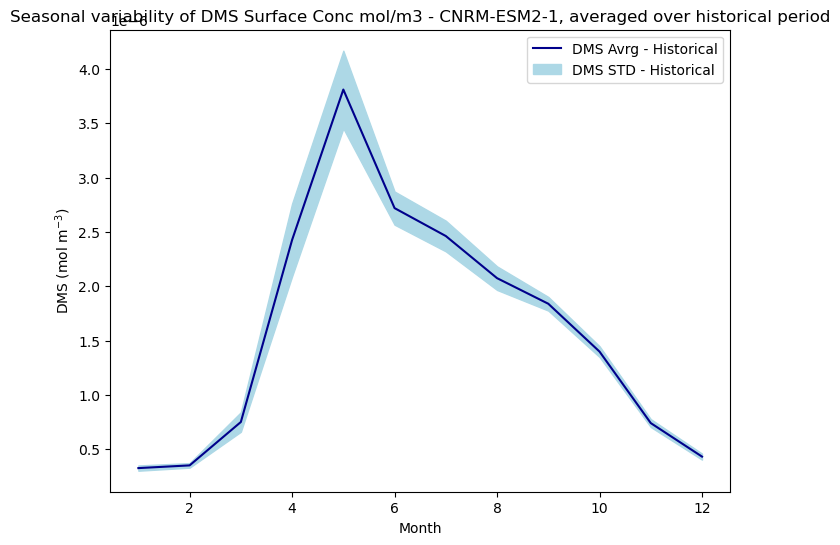

In [46]:
fig = plt.figure(figsize=(8,6))
plt_avrg=plt.plot(dmsset_AreaMean_MonthAvrg_GL.month,dmsset_AreaMean_MonthAvrg_GL, color='darkblue',
                  label='DMS Avrg - Historical'
                      )
plt.fill_between(dmsset_AreaMean_MonthAvrg_STD_GL.month,dmsset_AreaMean_MonthAvrg_GL
                 -0.5*dmsset_AreaMean_MonthAvrg_STD_GL,dmsset_AreaMean_MonthAvrg_GL
                 +0.5*dmsset_AreaMean_MonthAvrg_STD_GL,color='lightblue', label='DMS STD - Historical')
   
plt.xlabel('Month')
plt.ylabel('DMS (mol m$^{-3}$)')
plt.title('Seasonal variability of DMS Surface Conc mol/m3 - CNRM-ESM2-1, averaged over historical period')
plt.legend()


In [47]:
#dms_2003to2014_GL = dmsset_GLarea.isel(time = slice(1836,None)
#).compute() #.compute does the excution of the mean operation
dms_2003to2014_AreaMean_GL = (GLarea*dms_2003to2014_GL['dmso']
                               ).sum(dim=('x','y'))/GLarea.sum(dim=('x','y')
                              ,keep_attrs=True)
dms_2003to2014_AreaMean_GL


<xarray.DataArray (time: 144)>
dask.array<truediv, shape=(144,), dtype=float32, chunksize=(144,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 2003-01-16 12:00:00 ... 2014-12-16 12:00:00

In [48]:
dms_2003to2014_AreaMean_MonthlyMean_GL = dms_2003to2014_AreaMean_GL.groupby(
    'time.month').mean().compute()
dms_2003to2014_AreaMean_MonthlyMean_GL

<xarray.DataArray (month: 12)>
array([2.8692844e-07, 3.3930135e-07, 9.1022622e-07, 2.6846690e-06,
       3.9303745e-06, 2.6842674e-06, 2.3568157e-06, 2.1230023e-06,
       1.8380975e-06, 1.3918835e-06, 7.2163789e-07, 3.9253345e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [49]:
dms_2003to2014_AreaMean_MonthlySTD_GL = dms_2003to2014_AreaMean_GL.groupby(
    'time.month').std().compute()
dms_2003to2014_AreaMean_MonthlySTD_GL

<xarray.DataArray (month: 12)>
array([3.1542474e-08, 3.0158649e-08, 1.7975526e-07, 5.3365818e-07,
       4.2256227e-07, 2.2780962e-07, 1.5513461e-07, 2.1576862e-07,
       7.6062676e-08, 9.4885287e-08, 6.6500625e-08, 3.6778008e-08],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

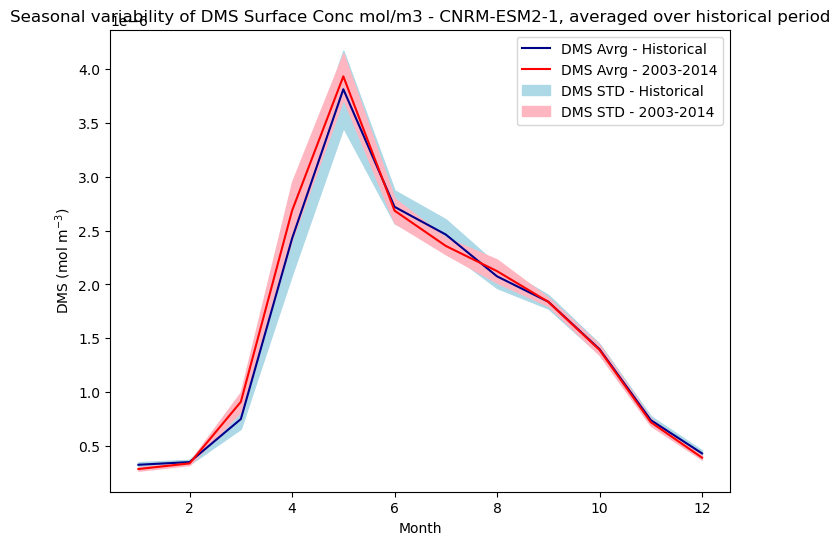

In [50]:
fig = plt.figure(figsize=(8,6))
plt_avrg=plt.plot(dmsset_AreaMean_MonthAvrg_GL.month,dmsset_AreaMean_MonthAvrg_GL, color='darkblue',
                      label='DMS Avrg - Historical')
plt.plot(dms_2003to2014_AreaMean_MonthlyMean_GL.month,
         dms_2003to2014_AreaMean_MonthlyMean_GL,color='red',label='DMS Avrg - 2003-2014')
plt.fill_between(dmsset_AreaMean_MonthAvrg_STD_GL.month,dmsset_AreaMean_MonthAvrg_GL
                 -0.5*dmsset_AreaMean_MonthAvrg_STD_GL,dmsset_AreaMean_MonthAvrg_GL
                 +0.5*dmsset_AreaMean_MonthAvrg_STD_GL,color='lightblue',label='DMS STD - Historical')
plt.fill_between(dms_2003to2014_AreaMean_MonthlySTD_GL.month,dms_2003to2014_AreaMean_MonthlyMean_GL
                 -0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,dms_2003to2014_AreaMean_MonthlyMean_GL
                 +0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,color='lightpink',label='DMS STD - 2003-2014')
   
plt.xlabel('Month')
plt.ylabel('DMS (mol m$^{-3}$)')
plt.title('Seasonal variability of DMS Surface Conc mol/m3 - CNRM-ESM2-1, averaged over historical period')
plt.legend()



In [51]:
dmsObs_2003to2014_GL

<xarray.Dataset>
Dimensions:      (pixel: 2386, time: 552)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year         (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.54 -9.54 -9.54 ... 8.372 8.372 8.372
    latitude     (pixel, time) float64 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan ... nan nan nan nan

In [52]:
dmsObs_2003to2014_AreaMean_GL = dmsObs_2003to2014_GL['dms'].mean(dim='pixel',keep_attrs=True).compute()
dmsObs_2003to2014_AreaMean_GL

<xarray.DataArray 'dms' (time: 552)>
array([       nan,        nan,        nan,        nan, 0.55945207,
       0.61036117, 0.61474586, 0.40717548, 0.42469626, 0.50493408,
       0.65412754, 0.78986508, 1.11157061, 1.73608581, 2.00877584,
       2.69666196, 3.94276819, 3.4199303 , 3.76568564, 4.50854489,
       5.99377313, 4.42219059, 5.07979565, 4.44321664, 4.29088575,
       3.89624378, 3.69469741, 2.87180825, 2.65168686, 2.24854374,
       1.97708954, 1.70752819, 1.36352544, 1.29317867, 1.03364068,
       0.95308372, 0.92492209, 0.77738615,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.56880644, 0.60058186, 0.60074637, 0.41767557, 0.47230139,
       0.57331986, 0.75158818, 0.82855318, 0.9316595 , 1.34262097,
       1.7235165 , 2.83207014, 3.90966255, 3.58018395, 5.26449711,
       5.66849683, 5.28489846, 6.15896252, 5.23327811, 5.48475811,
       4.60069541, 4.13087242, 3.65061042, 3.48864909, 3.18131074,
       2.95328516, 2.07054728, 1.70502202, 1.37759111, 1.14366126,
       1.0857936 , 0.97200827, 0.92121812, 0.68712278,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.56533875, 0.60120225, 0.66088031, 0.42058952,
...
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.59093047,
       0.61757264, 0.7155015 , 0.45854445, 0.58644498, 0.65755627,
       0.92061299, 1.04026898, 1.2898372 , 1.12403057, 1.60143717,
       1.91505213, 2.70771689, 3.03584056, 5.05207826, 6.27418432,
       5.78876214, 4.55330967, 5.71737663, 4.37993043, 3.81331363,
       4.12190617, 2.91677231, 3.23680944, 2.5045535 , 2.16105886,
       2.01199902, 1.67441467, 1.48378758, 1.40154346, 1.07531573,
       1.02542376, 0.91451058, 1.31598312,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.56299798, 0.61414656, 0.64797305, 0.4402731 , 0.44603204,
       0.52697729, 0.77443465, 0.80205175, 1.17971318, 1.49511752,
       1.86410644, 2.45003086, 3.51762699, 3.48604379, 3.84536067,
       4.57565605, 5.38477052, 5.40047803, 4.52205284, 4.57714129,
       3.92102799, 3.22977606, 2.81544174, 2.47619129, 2.14827451,
       2.36728196, 1.44753001, 1.34747341, 1.20384117, 1.15524172,
       1.05595833, 1.01212713, 0.89614402, 0.75085429,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan])
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year     (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period   (time) int64 0 1 2 3 4 5 6 7 8 9 ... 36 37 38 39 40 41 42 43 44 45

In [53]:
dmsObs_2003to2014_AreaMean_MonthlyMean_GL = dmsObs_2003to2014_AreaMean_GL.groupby(
    'time.month').mean().compute()
dmsObs_2003to2014_AreaMean_MonthlyMean_GL=1.0e-6*dmsObs_2003to2014_AreaMean_MonthlyMean_GL
dmsObs_2003to2014_AreaMean_MonthlyMean_GL

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.DataArray 'dms' (month: 12)>
array([           nan, 5.67791067e-07, 6.24737387e-07, 1.50263289e-06,
       3.61108127e-06, 5.63573394e-06, 4.12576223e-06, 2.57537966e-06,
       1.37337684e-06, 9.15369399e-07,            nan,            nan])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [54]:
dmsObs_2003to2014_AreaMean_MonthlySTD_GL = dmsObs_2003to2014_AreaMean_GL.groupby(
    'time.month').std().compute()
dmsObs_2003to2014_AreaMean_MonthlySTD_GL=1.0e-6*dmsObs_2003to2014_AreaMean_MonthlySTD_GL
dmsObs_2003to2014_AreaMean_MonthlySTD_GL

<xarray.DataArray 'dms' (month: 12)>
array([           nan, 9.02693152e-08, 1.49441679e-07, 4.51523697e-07,
       9.82690207e-07, 7.57278703e-07, 8.57871110e-07, 4.88082928e-07,
       2.44011526e-07, 1.62705751e-07,            nan,            nan])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

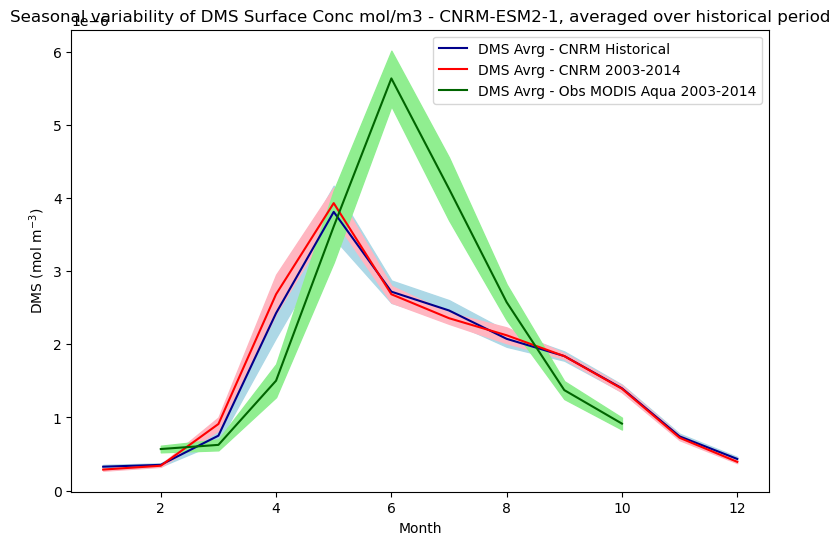

In [55]:
## Seasonality figure
## I should add to it 2 things:
## 1- first and last 30 years
## 2- the same but from UKSM
fig = plt.figure(figsize=(9,6))
plt_avrg=plt.plot(dmsset_AreaMean_MonthAvrg_GL.month,dmsset_AreaMean_MonthAvrg_GL, color='darkblue',
                      label='DMS Avrg - CNRM Historical')
plt.plot(dms_2003to2014_AreaMean_MonthlyMean_GL.month,
         dms_2003to2014_AreaMean_MonthlyMean_GL,color='red',label='DMS Avrg - CNRM 2003-2014')

plt.plot(dmsObs_2003to2014_AreaMean_MonthlyMean_GL.month,
         dmsObs_2003to2014_AreaMean_MonthlyMean_GL,color='darkgreen',
          label='DMS Avrg - Obs MODIS Aqua 2003-2014')

plt.fill_between(dmsset_AreaMean_MonthAvrg_STD_GL.month,dmsset_AreaMean_MonthAvrg_GL
                 -0.5*dmsset_AreaMean_MonthAvrg_STD_GL,dmsset_AreaMean_MonthAvrg_GL
                 +0.5*dmsset_AreaMean_MonthAvrg_STD_GL,color='lightblue')
#                 label='DMS STD - CNRM Historical')

plt.fill_between(dms_2003to2014_AreaMean_MonthlySTD_GL.month,dms_2003to2014_AreaMean_MonthlyMean_GL
                 -0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,dms_2003to2014_AreaMean_MonthlyMean_GL
                 +0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,color='lightpink',)
#                 label='DMS STD - CNRM 2003-2014')

plt.fill_between(dmsObs_2003to2014_AreaMean_MonthlySTD_GL.month,
                 dmsObs_2003to2014_AreaMean_MonthlyMean_GL
                 -0.5*dmsObs_2003to2014_AreaMean_MonthlySTD_GL,
                 dmsObs_2003to2014_AreaMean_MonthlyMean_GL
                 +0.5*dmsObs_2003to2014_AreaMean_MonthlySTD_GL,color='lightgreen',)
#                 label='DMS STD - Obs MODIS Aqua 2003-2014')   
plt.xlabel('Month')
plt.ylabel('DMS (mol m$^{-3}$)')
plt.title('Seasonal variability of DMS Surface Conc mol/m3 - CNRM-ESM2-1, averaged over historical period')
plt.legend()
plt.savefig('DMS_SurfConc_Seasonality_GLarea_CNRM_vs_ObsModisAqua.png')

### selecting the first and last 30 years of historical

In [56]:
#dmsset_GLarea
#dms_2003to2014_GL
## first 30 years
dms_1850to1880_GL = dmsset_GLarea.isel(time = slice(372)).compute() #.compute does the excution of the mean operation
dms_1850to1880_GL

<xarray.Dataset>
Dimensions:      (time: 372, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon   (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 52.85 52.1
    lat          (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 -18.25 -17.08 -15.91 ... 49.82 50.68 51.49
  * time         (time) object 1850-01-16 12:00:00 ... 1880-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 1850-01-01 00:00:00 ... 1881-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

In [57]:
dms_1850to1880_AreaAvrg_GL = (GLarea*dms_1850to1880_GL['dmso']
                               ).sum(dim=('x','y'))/GLarea.sum(dim=('x','y')
                              ,keep_attrs=True)
dms_1850to1880_AreaAvrg_GL

<xarray.DataArray (time: 372)>
dask.array<truediv, shape=(372,), dtype=float32, chunksize=(372,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1850-01-16 12:00:00 ... 1880-12-16 12:00:00

In [58]:
dms_1850to1880_AreaMean_MonthlyMean_GL = dms_1850to1880_AreaAvrg_GL.groupby(
    'time.month').mean().compute()
dms_1850to1880_AreaMean_MonthlyMean_GL

<xarray.DataArray (month: 12)>
array([2.9747738e-07, 3.3656838e-07, 7.6186291e-07, 2.5273241e-06,
       4.2803117e-06, 2.7427511e-06, 2.3712794e-06, 2.0678572e-06,
       1.8380725e-06, 1.4135104e-06, 7.1555650e-07, 4.0446324e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [59]:
dms_1850to1880_AreaMean_MonthlySTD_GL = dms_1850to1880_AreaAvrg_GL.groupby(
    'time.month').std().compute()
dms_1850to1880_AreaMean_MonthlySTD_GL

<xarray.DataArray (month: 12)>
array([3.6905384e-08, 3.7736342e-08, 1.7841091e-07, 6.1237034e-07,
       6.6373013e-07, 2.6453205e-07, 2.1754440e-07, 2.1906023e-07,
       9.9294411e-08, 8.6127770e-08, 6.5413104e-08, 4.3848701e-08],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [60]:
## last 30 years
dms_1984to2014_GL = dmsset_GLarea.isel(time = slice(1608,None)).compute() #.compute does the excution of the mean operation
dms_1984to2014_GL

<xarray.Dataset>
Dimensions:      (time: 372, y: 46, x: 25, nvertex: 4, axis_nbounds: 2)
Coordinates:
    bounds_lat   (y, x, nvertex) float64 60.57 60.53 61.14 ... 76.87 77.05 77.47
    bounds_lon   (y, x, nvertex) float64 -18.87 -17.7 -17.62 ... 52.85 52.1
    lat          (y, x) float64 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    lev          float64 0.5058
    lev_bounds   (axis_nbounds) float64 0.0 1.024
    lon          (y, x) float64 -18.25 -17.08 -15.91 ... 49.82 50.68 51.49
  * time         (time) object 1984-01-16 12:00:00 ... 2014-12-16 12:00:00
    time_bounds  (time, axis_nbounds) object 1984-01-01 00:00:00 ... 2015-01-...
    member_id    <U8 'r1i1p1f2'
Dimensions without coordinates: y, x, nvertex, axis_nbounds
Data variables:
    dmso         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/57)
    CMIP6_CV_version:        cv=6.2.3.0-7-g2019642
    Conventions:             CF-1.7 CMIP-6.2
    EXPID:                   CNRM-ESM2-1_historical_r1i1p1f2_v2
    activity_id:             CMIP
    arpege_minor_version:    6.3.2
    branch_method:           standard
    ...                      ...
    variant_label:           r1i1p1f2
    xios_commit:             1442-shuffle
    netcdf_tracking_ids:     hdl:21.14100/75203d21-77b5-4211-b329-53b412b9c8a...
    version_id:              v20181206
    intake_esm_varname:      ['dmso']
    intake_esm_dataset_key:  CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn

In [61]:
dms_1984to2014_AreaAvrg_GL = (GLarea*dms_1984to2014_GL['dmso']
                               ).sum(dim=('x','y'))/GLarea.sum(dim=('x','y')
                              ,keep_attrs=True)
dms_1984to2014_AreaAvrg_GL

<xarray.DataArray (time: 372)>
dask.array<truediv, shape=(372,), dtype=float32, chunksize=(372,), chunktype=numpy.ndarray>
Coordinates:
    member_id  <U8 'r1i1p1f2'
    lev        float64 0.5058
  * time       (time) object 1984-01-16 12:00:00 ... 2014-12-16 12:00:00

In [62]:
dms_1984to2014_AreaMean_MonthlyMean_GL = dms_1984to2014_AreaAvrg_GL.groupby(
    'time.month').mean().compute()
dms_1984to2014_AreaMean_MonthlyMean_GL

<xarray.DataArray (month: 12)>
array([2.9498108e-07, 3.3118511e-07, 8.2003334e-07, 2.6686339e-06,
       4.0414552e-06, 2.6681867e-06, 2.3178306e-06, 2.0893899e-06,
       1.8749523e-06, 1.4003360e-06, 7.2415435e-07, 4.0094815e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [63]:
dms_1984to2014_AreaMean_MonthlySTD_GL = dms_1984to2014_AreaAvrg_GL.groupby(
    'time.month').std().compute()
dms_1984to2014_AreaMean_MonthlySTD_GL

<xarray.DataArray (month: 12)>
array([2.7317833e-08, 2.9486614e-08, 1.6687481e-07, 6.3014363e-07,
       4.7953642e-07, 2.6574156e-07, 1.8586016e-07, 1.9282508e-07,
       1.1358506e-07, 9.1537480e-08, 5.6274430e-08, 3.5673459e-08],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

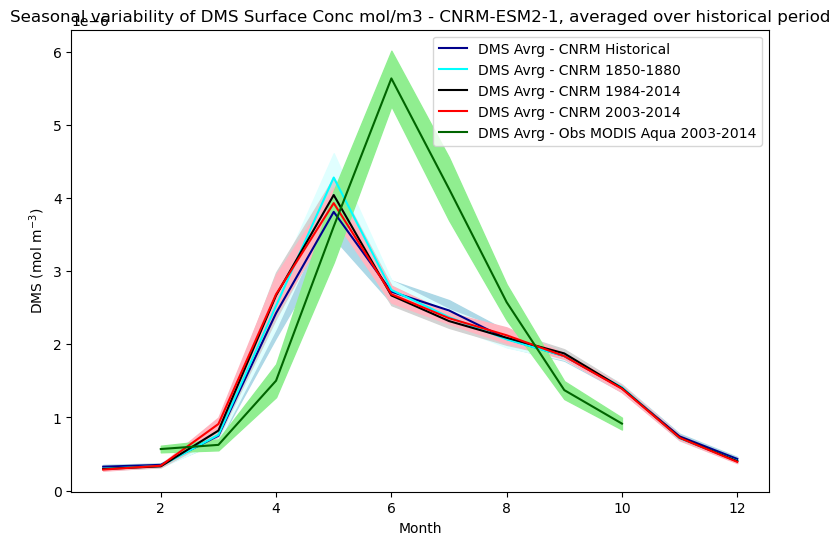

In [64]:
## Seasonality figure
## I should add to it 2 things:
## 1- first and last 30 years
## 2- the same but from UKSM
fig = plt.figure(figsize=(9,6))
plt_avrg=plt.plot(dmsset_AreaMean_MonthAvrg_GL.month,dmsset_AreaMean_MonthAvrg_GL, color='darkblue',
                      label='DMS Avrg - CNRM Historical')
plt.plot(dms_1850to1880_AreaMean_MonthlyMean_GL.month,
         dms_1850to1880_AreaMean_MonthlyMean_GL,color='cyan',
          label='DMS Avrg - CNRM 1850-1880')
plt.plot(dms_1984to2014_AreaMean_MonthlyMean_GL.month,
         dms_1984to2014_AreaMean_MonthlyMean_GL,color='black',
          label='DMS Avrg - CNRM 1984-2014')
plt.plot(dms_2003to2014_AreaMean_MonthlyMean_GL.month,
         dms_2003to2014_AreaMean_MonthlyMean_GL,color='red',label='DMS Avrg - CNRM 2003-2014')
plt.plot(dmsObs_2003to2014_AreaMean_MonthlyMean_GL.month,
         dmsObs_2003to2014_AreaMean_MonthlyMean_GL,color='darkgreen',
          label='DMS Avrg - Obs MODIS Aqua 2003-2014')

plt.fill_between(dmsset_AreaMean_MonthAvrg_STD_GL.month,dmsset_AreaMean_MonthAvrg_GL
                 -0.5*dmsset_AreaMean_MonthAvrg_STD_GL,dmsset_AreaMean_MonthAvrg_GL
                 +0.5*dmsset_AreaMean_MonthAvrg_STD_GL,color='lightblue')
plt.fill_between(dms_1850to1880_AreaMean_MonthlySTD_GL.month,
                 dms_1850to1880_AreaMean_MonthlyMean_GL
                 -0.5*dms_1850to1880_AreaMean_MonthlySTD_GL,
                 dms_1850to1880_AreaMean_MonthlyMean_GL
                 +0.5*dms_1850to1880_AreaMean_MonthlySTD_GL,color='lightcyan',)
plt.fill_between(dms_1984to2014_AreaMean_MonthlySTD_GL.month,
                 dms_1984to2014_AreaMean_MonthlyMean_GL
                 -0.5*dms_1984to2014_AreaMean_MonthlySTD_GL,
                 dms_1984to2014_AreaMean_MonthlyMean_GL
                 +0.5*dms_1984to2014_AreaMean_MonthlySTD_GL,color='lightgray',)
plt.fill_between(dms_2003to2014_AreaMean_MonthlySTD_GL.month,dms_2003to2014_AreaMean_MonthlyMean_GL
                 -0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,dms_2003to2014_AreaMean_MonthlyMean_GL
                 +0.5*dms_2003to2014_AreaMean_MonthlySTD_GL,color='lightpink',)
plt.fill_between(dmsObs_2003to2014_AreaMean_MonthlySTD_GL.month,
                 dmsObs_2003to2014_AreaMean_MonthlyMean_GL
                 -0.5*dmsObs_2003to2014_AreaMean_MonthlySTD_GL,
                 dmsObs_2003to2014_AreaMean_MonthlyMean_GL
                 +0.5*dmsObs_2003to2014_AreaMean_MonthlySTD_GL,color='lightgreen',)
#                 label='DMS STD - Obs MODIS Aqua 2003-2014')
plt.xlabel('Month')
plt.ylabel('DMS (mol m$^{-3}$)')
plt.title('Seasonal variability of DMS Surface Conc mol/m3 - CNRM-ESM2-1, averaged over historical period')
plt.legend()
plt.savefig('DMS_SurfConc_Seasonality_GLarea_CNRM_vs_ObsModisAqua.png')

## Now try UKESM-1-0-LL

In [65]:
import xarray as xr
import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))
# list avilable data in the bucket
s3.ls('escience2022/Ada/monthly')
dir = 'escience2022/Ada/monthly'
files = [file for file in s3.ls(dir) if 'dmsos' in file ]
#files = [file for file in s3.ls(dir) if 'emidms' in file ]
files

['escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_esm-hist_r1i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r10i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r1i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r2i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r3i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r4i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r5i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r6i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r7i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r8i1p1f2_gn_185001-201412.nc',
 'escience2022/Ada/monthly/dmsos_Omon_CNRM-ESM2-1_historical_r9i1p1f2_gn_185001-2

In [66]:
## for UKESM
# path to the file: bucket/forlder/filename.nc
#list of member id in the bucket to add it as a dimension
list_member_id = ['1', '2', '3', '4','8','9']
list_ds = []
for imember, member in enumerate(list_member_id):
    remote_files = 's3://escience2022/Ada/monthly/dmsos_Omon_UKESM1-0-LL_historical_r'+member+'*.nc'
    remote_files = s3.glob(remote_files)
    fileset = [s3.open(file) for file in remote_files]
    list_ds.append(xr.open_mfdataset(fileset, combine='by_coords'))
## merge all the ensembles files 
ds = xr.concat(list_ds,"member_id")

In [67]:
ds['member_id']=['r'+list_member_id[i] for i in range(len(list_member_id))]
ds

<xarray.Dataset>
Dimensions:             (time: 1980, member_id: 6, bnds: 2, j: 330, i: 360,
                         vertices: 4)
Coordinates:
  * time                (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:0...
  * j                   (j) int32 0 1 2 3 4 5 6 ... 323 324 325 326 327 328 329
  * i                   (i) int32 0 1 2 3 4 5 6 ... 353 354 355 356 357 358 359
    latitude            (j, i) float32 -84.11 -84.11 -84.11 ... 50.23 50.01
    longitude           (j, i) float32 73.5 74.5 75.5 76.5 ... 72.95 72.96 72.99
  * member_id           (member_id) <U2 'r1' 'r2' 'r3' 'r4' 'r8' 'r9'
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (member_id, time, bnds) object dask.array<chunksize=(1, 1200, 2), meta=np.ndarray>
    vertices_latitude   (member_id, time, j, i, vertices) float32 dask.array<chunksize=(1, 1200, 330, 360, 4), meta=np.ndarray>
    vertices_longitude  (member_id, time, j, i, vertices) float32 dask.array<chunksize=(1, 1200, 330, 360, 4), meta=np.ndarray>
    dmsos               (member_id, time, j, i) float32 dask.array<chunksize=(1, 1200, 330, 360), meta=np.ndarray>
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  144000.0
    creation_date:          2020-02-28T17:10:38Z
    ...                     ...
    variable_id:            dmsos
    variable_name:          dmsos
    variant_label:          r1i1p1f2
    license:                CMIP6 model data produced by the Met Office Hadle...
    cmor_version:           3.4.0
    tracking_id:            hdl:21.14100/4f3d6938-2525-420b-928f-15ff7946a63f

In [68]:
with ProgressBar():
    ds_dmsos = ds.dmsos.mean(dim=['member_id']).compute()
ds_dmsos

[########################################] | 100% Completed | 210.85 s


<xarray.DataArray 'dmsos' (time: 1980, j: 330, i: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * j          (j) int32 0 1 2 3 4 5 6 7 8 ... 322 323 324 325 326 327 328 329
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 352 353 354 355 356 357 358 359
    latitude   (j, i) float32 -84.11 -84.11 -84.11 -84.11 ... 50.51 50.23 50.01
    longitude  (j, i) float32 73.5 74.5 75.5 76.5 ... 72.93 72.95 72.96 72.99

In [69]:
## make an data array for whole time average for the first member_id
## this option can be used in case the server is too slow
list_means_time = []
for im, m in enumerate(list_ds):
    list_means_time.append(list_ds[0].dmsos.mean(dim='time'))
ds_means_time = xr.concat(list_means_time,"member_id")

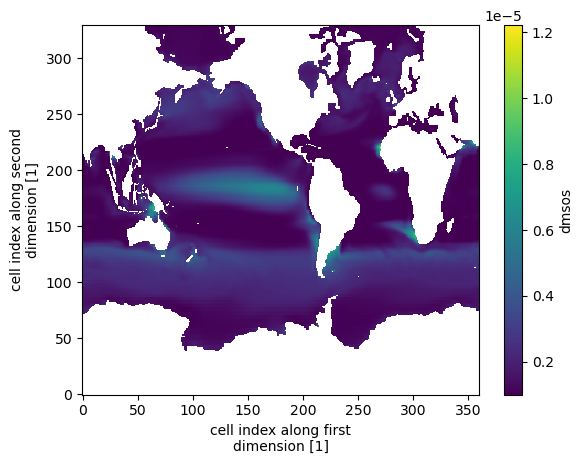

In [70]:
ds_means_time.mean(dim='member_id').compute().plot()

In [71]:
## Greenland
dmsosset_UKESM_GLarea = ds_dmsos.where((ds_dmsos.longitude>=-10) 
                                       & (ds_dmsos.longitude<=10) 
                                       & (ds_dmsos.latitude <= 85)  
                                       & (ds_dmsos.latitude >= 60),
                         drop=True).compute()
dmsosset_UKESM_GLarea

<xarray.DataArray 'dmsos' (time: 1980, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 2014-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

In [72]:
dms_AnnMeanAllHistrorical_UKESM_GL = dmsosset_UKESM_GLarea.mean(dim='time',keep_attrs=True).compute() #.compute does the excution of the mean operation
dms_AnnMeanAllHistrorical_UKESM_GL

<xarray.DataArray 'dmsos' (j: 46, i: 25)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [1.1039598e-06, 1.0935676e-06, 1.0872878e-06, ...,           nan,
                  nan,           nan],
       [1.1085212e-06, 1.0982201e-06, 1.0934904e-06, ...,           nan,
                  nan,           nan],
       [          nan,           nan, 1.0958296e-06, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

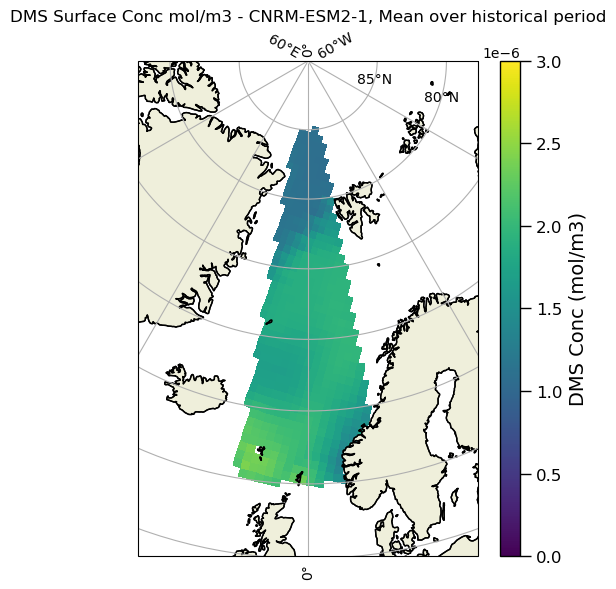

In [73]:
fig, ax = plt.subplots(figsize=(6,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax.set_extent([-20, 20,55,90], ccrs.PlateCarree())



pl_CMIP6=ax.pcolormesh(dms_AnnMeanAllHistrorical_UKESM_GL.longitude, 
                       dms_AnnMeanAllHistrorical_UKESM_GL.latitude,
              dms_AnnMeanAllHistrorical_UKESM_GL, 
    vmin=0,vmax=3.0e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax.add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax.set_title('DMS Surface Conc mol/m3 - CNRM-ESM2-1, Mean over historical period')
ax.gridlines(draw_labels=True)
ax.coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
fig.tight_layout()
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax,
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )
# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Conc (mol/m3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)

def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)

/tmp/ipykernel_2747/2042574098.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


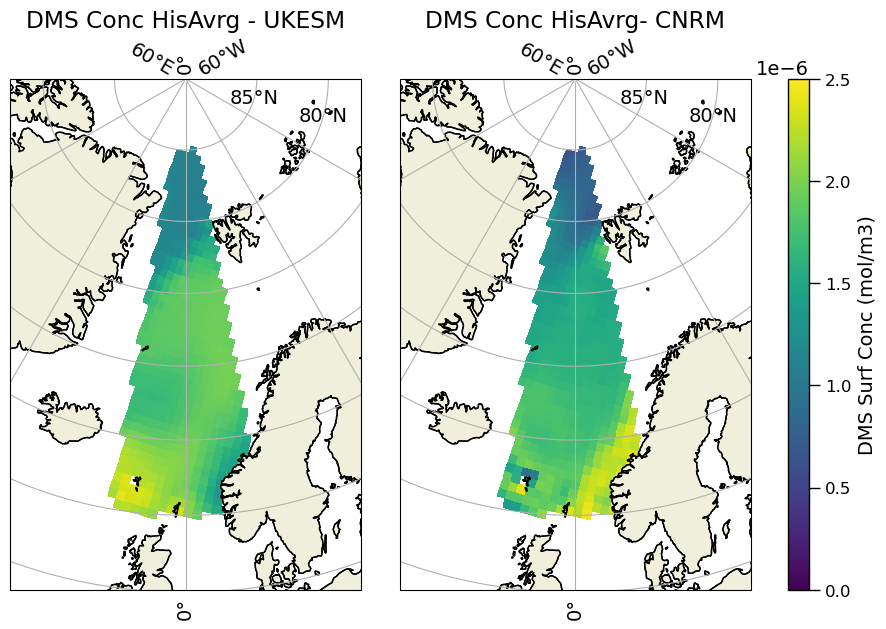

In [107]:
mpl.rcParams.update({'font.size':14})
fig, ax = plt.subplots(1,2,figsize=(8,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax[0].set_extent([-20, 20,55,90], ccrs.PlateCarree())
ax[1].set_extent([-20, 20,55,90], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_AnnMeanAllHistrorical_UKESM_GL.longitude,
                       dms_AnnMeanAllHistrorical_UKESM_GL.latitude,
              dms_AnnMeanAllHistrorical_UKESM_GL, 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('DMS Conc HisAvrg - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()

pl_CNRM=ax[1].pcolormesh(dms_AnnMean_AllHistrorical_GL.lon,
                       dms_AnnMean_AllHistrorical_GL.lat,
              dms_AnnMean_AllHistrorical_GL['dmso'], 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('DMS Conc HisAvrg- CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[1],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Surf Conc (mol/m3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('DMS_SurfConc_UKESM_vs_CNRM_Greenland_HistoricalAvrg.png')

In [75]:
## selecting threee periods 
## 1- 2003 to 2014,  
dms_2003to2014_UKESM_GL = dmsosset_UKESM_GLarea.isel(time = slice(1836,None)).compute() 
dms_2003to2014_UKESM_GL



<xarray.DataArray 'dmsos' (time: 144, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 2003-01-16 00:00:00 ... 2014-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

In [76]:
dms_AnnMean2003to2014_UKESM_GL = dms_2003to2014_UKESM_GL.mean(dim='time',keep_attrs=True).compute() 
dms_AnnMean2003to2014_UKESM_GL

<xarray.DataArray 'dmsos' (j: 46, i: 25)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [1.0983363e-06, 1.0965830e-06, 1.0991473e-06, ...,           nan,
                  nan,           nan],
       [1.1063772e-06, 1.1065072e-06, 1.1100525e-06, ...,           nan,
                  nan,           nan],
       [          nan,           nan, 1.1157925e-06, ...,           nan,
                  nan,           nan]], dtype=float32)
Coordinates:
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

/tmp/ipykernel_2747/1372558684.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


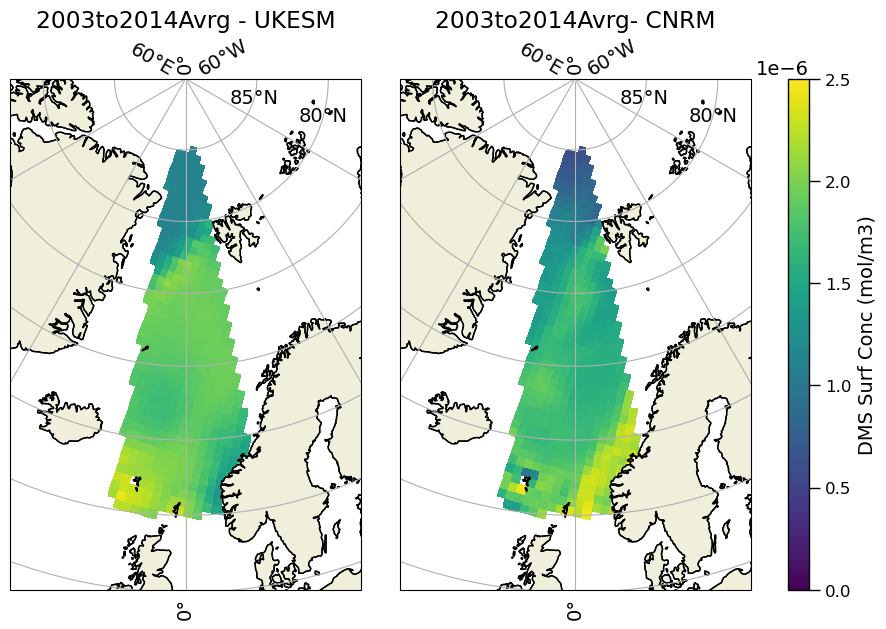

In [104]:
mpl.rcParams.update({'font.size':14})
fig, ax = plt.subplots(1,2,figsize=(8,6),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax[0].set_extent([-20, 20,55,90], ccrs.PlateCarree())
ax[1].set_extent([-20, 20,55,90], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_AnnMean2003to2014_UKESM_GL.longitude,
                       dms_AnnMean2003to2014_UKESM_GL.latitude,
              dms_AnnMean2003to2014_UKESM_GL, 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('2003to2014Avrg - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()

pl_CNRM=ax[1].pcolormesh(dms_AnnMean_2003to2014_GL.lon,
                         dms_AnnMean_2003to2014_GL.lat,
              dms_AnnMean_2003to2014_GL['dmso'], 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('2003to2014Avrg- CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[1],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Surf Conc (mol/m3)', fontsize=14)

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('DMS_SurfConc_UKESM_vs_CNRM_Greenland_2003to2014Avrg.png')

/tmp/ipykernel_2747/228973652.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


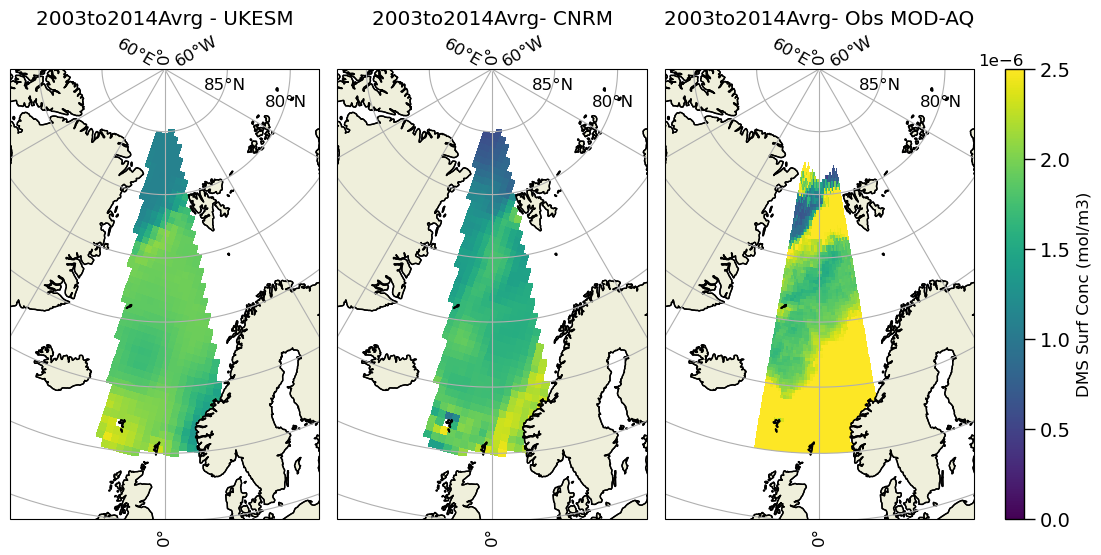

In [176]:
mpl.rcParams.update({'font.size':12})
fig, ax = plt.subplots(1,3,figsize=(10,10),subplot_kw={'projection':ccrs.NorthPolarStereo()})
ax[0].set_extent([-20, 20,55,90], ccrs.PlateCarree())
ax[1].set_extent([-20, 20,55,90], ccrs.PlateCarree())
ax[2].set_extent([-20, 20,55,90], ccrs.PlateCarree())
pl_UKESM=ax[0].pcolormesh(dms_AnnMean2003to2014_UKESM_GL.longitude,
                       dms_AnnMean2003to2014_UKESM_GL.latitude,
              dms_AnnMean2003to2014_UKESM_GL, 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[0].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[0].set_title('2003to2014Avrg - UKESM')
ax[0].gridlines(draw_labels=True)
ax[0].coastlines()

pl_CNRM=ax[1].pcolormesh(dms_AnnMean_2003to2014_GL.lon,
                         dms_AnnMean_2003to2014_GL.lat,
              dms_AnnMean_2003to2014_GL['dmso'], 
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[1].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[1].set_title('2003to2014Avrg- CNRM')
ax[1].gridlines(draw_labels=True)
ax[1].coastlines()

pl_Obs=ax[2].pcolormesh(dmsObs_AnnMean_2003to2014_GL.lon,
                        dmsObs_AnnMean_2003to2014_GL.lat,
                        dmsObs_AnnMean_2003to2014_GL*1.0e-6,
    vmin=0,vmax=2.5e-6,          
    transform=ccrs.PlateCarree(),
    # transform=ccrs.AlbersEqualArea(),
    # levels=10,
        )
ax[2].add_feature(cartopy.feature.LAND, zorder=1, edgecolor='black')
ax[2].set_title('2003to2014Avrg- Obs MOD-AQ')
ax[2].gridlines(draw_labels=True)
ax[2].coastlines()
#fig.colorbar(pl_CMIP6,shrink=0.4)
############# COLORBAR properties ##############
# create the ax based on an ax dimensions
axins = inset_axes(ax[2],
                    width="6%",  
                    height="100%",
                    loc='right',
                    borderpad=-3
                   )

# add colorbar from ax
cbar = fig.colorbar(pl_CMIP6, cax=axins, orientation='vertical')
cbar = fig.colorbar(pl_CNRM, cax=axins, orientation='vertical')
# style(axins)
cbar.set_label('DMS Surf Conc (mol/m3)')

# thickness of spines around the colorbar
cbar.outline.set_linewidth(1)
fig.tight_layout()
def style_cbar(ax):
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='both', length=8, width=1, direction='out')

style_cbar(axins)
plt.savefig('DMS_SurfConc_UKESM_vs_CNRM_vs_Obs_Greenland_2003to2014Avrg.png')

In [110]:
dms_AreaMean2003to2014_UKESM_GL = dms_2003to2014_UKESM_GL.mean(dim=('i','j')).compute()
dms_AreaMean2003to2014_UKESM_GL

<xarray.DataArray 'dmsos' (time: 144)>
array([1.0000000e-06, 1.0042764e-06, 1.1393198e-06, 2.0215759e-06,
       3.9625147e-06, 4.1850753e-06, 1.8819401e-06, 1.0547784e-06,
       1.0285886e-06, 1.0018882e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000000e-06, 1.0023094e-06, 1.1278231e-06, 2.1311810e-06,
       4.4297985e-06, 4.4373865e-06, 1.8143949e-06, 1.0477754e-06,
       1.0227474e-06, 1.0023319e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000001e-06, 1.0024671e-06, 1.1290184e-06, 2.1546625e-06,
       4.2272914e-06, 4.8704042e-06, 2.0002035e-06, 1.1302716e-06,
       1.0252737e-06, 1.0018978e-06, 1.0000001e-06, 1.0000000e-06,
       1.0000000e-06, 1.0035011e-06, 1.1461578e-06, 2.3660652e-06,
       4.3370810e-06, 4.5536794e-06, 2.0765235e-06, 1.1689320e-06,
       1.0345531e-06, 1.0009085e-06, 1.0000036e-06, 1.0000000e-06,
       1.0000009e-06, 1.0016524e-06, 1.1622892e-06, 2.4368039e-06,
       4.2793749e-06, 4.5587522e-06, 1.9050286e-06, 1.0705052e-06,
       1.0112389e-06, 1.0007336e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000000e-06, 1.0024868e-06, 1.1699797e-06, 2.3601381e-06,
       4.3282344e-06, 4.0335408e-06, 1.7599525e-06, 1.0896175e-06,
       1.0128344e-06, 1.0007382e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000000e-06, 1.0042683e-06, 1.1279618e-06, 2.1461772e-06,
       4.1635144e-06, 4.3843311e-06, 2.0016112e-06, 1.1040727e-06,
       1.0186204e-06, 1.0031844e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000000e-06, 1.0015254e-06, 1.1392982e-06, 2.2919078e-06,
       3.9139290e-06, 4.6472792e-06, 2.0324587e-06, 1.1037649e-06,
       1.0281988e-06, 1.0009743e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000000e-06, 1.0016237e-06, 1.0977194e-06, 2.0984826e-06,
       4.0716004e-06, 4.9210344e-06, 2.2313216e-06, 1.1594863e-06,
       1.0216659e-06, 1.0018010e-06, 1.0000011e-06, 1.0000000e-06,
       1.0000000e-06, 1.0031796e-06, 1.1449077e-06, 2.2262091e-06,
       4.2109855e-06, 4.5283455e-06, 1.9748018e-06, 1.1323486e-06,
       1.0212284e-06, 1.0011753e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000000e-06, 1.0022354e-06, 1.1289197e-06, 2.2495162e-06,
       3.9292422e-06, 4.4506319e-06, 2.1249832e-06, 1.0936249e-06,
       1.0178910e-06, 1.0014268e-06, 1.0000000e-06, 1.0000000e-06,
       1.0000000e-06, 1.0018033e-06, 1.2305732e-06, 2.2797387e-06,
       3.8828794e-06, 4.5326155e-06, 2.0590708e-06, 1.1054484e-06,
       1.0235224e-06, 1.0023242e-06, 1.0000051e-06, 1.0000000e-06],
      dtype=float32)
Coordinates:
  * time     (time) object 2003-01-16 00:00:00 ... 2014-12-16 00:00:00

In [112]:
dmsObs_2003to2014_AreaMean_GL

<xarray.DataArray 'dms' (time: 552)>
array([       nan,        nan,        nan,        nan, 0.55945207,
       0.61036117, 0.61474586, 0.40717548, 0.42469626, 0.50493408,
       0.65412754, 0.78986508, 1.11157061, 1.73608581, 2.00877584,
       2.69666196, 3.94276819, 3.4199303 , 3.76568564, 4.50854489,
       5.99377313, 4.42219059, 5.07979565, 4.44321664, 4.29088575,
       3.89624378, 3.69469741, 2.87180825, 2.65168686, 2.24854374,
       1.97708954, 1.70752819, 1.36352544, 1.29317867, 1.03364068,
       0.95308372, 0.92492209, 0.77738615,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.56880644, 0.60058186, 0.60074637, 0.41767557, 0.47230139,
       0.57331986, 0.75158818, 0.82855318, 0.9316595 , 1.34262097,
       1.7235165 , 2.83207014, 3.90966255, 3.58018395, 5.26449711,
       5.66849683, 5.28489846, 6.15896252, 5.23327811, 5.48475811,
       4.60069541, 4.13087242, 3.65061042, 3.48864909, 3.18131074,
       2.95328516, 2.07054728, 1.70502202, 1.37759111, 1.14366126,
       1.0857936 , 0.97200827, 0.92121812, 0.68712278,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan, 0.56533875, 0.60120225, 0.66088031, 0.42058952,
...
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan, 0.59093047,
       0.61757264, 0.7155015 , 0.45854445, 0.58644498, 0.65755627,
       0.92061299, 1.04026898, 1.2898372 , 1.12403057, 1.60143717,
       1.91505213, 2.70771689, 3.03584056, 5.05207826, 6.27418432,
       5.78876214, 4.55330967, 5.71737663, 4.37993043, 3.81331363,
       4.12190617, 2.91677231, 3.23680944, 2.5045535 , 2.16105886,
       2.01199902, 1.67441467, 1.48378758, 1.40154346, 1.07531573,
       1.02542376, 0.91451058, 1.31598312,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       0.56299798, 0.61414656, 0.64797305, 0.4402731 , 0.44603204,
       0.52697729, 0.77443465, 0.80205175, 1.17971318, 1.49511752,
       1.86410644, 2.45003086, 3.51762699, 3.48604379, 3.84536067,
       4.57565605, 5.38477052, 5.40047803, 4.52205284, 4.57714129,
       3.92102799, 3.22977606, 2.81544174, 2.47619129, 2.14827451,
       2.36728196, 1.44753001, 1.34747341, 1.20384117, 1.15524172,
       1.05595833, 1.01212713, 0.89614402, 0.75085429,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan])
Coordinates:
  * time     (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year     (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period   (time) int64 0 1 2 3 4 5 6 7 8 9 ... 36 37 38 39 40 41 42 43 44 45

In [118]:
dmsObs_mthlymean = dmsObs_2003to2014_AreaMean_GL.resample(time='d').nearest().resample(time='m').mean()
dmsObs_mthlymean

/srv/conda/envs/notebook/lib/python3.9/site-packages/flox/aggregate_flox.py:105: RuntimeWarning: invalid value encountered in divide
  out /= nanlen(group_idx, array, size=size, axis=axis, fill_value=0)


<xarray.DataArray 'dms' (time: 144)>
array([0.55945207, 0.5517266 , 0.57472351, 1.7072612 , 3.65610824,
       5.03173387, 4.0695849 , 2.45212702, 1.40197171, 0.90163177,
              nan,        nan, 0.56880644, 0.54469181, 0.65088864,
       1.56570932, 4.29693376, 5.56868721, 4.36950399, 2.90521577,
       1.34416523, 0.87747617,        nan,        nan, 0.56533875,
       0.56669575, 0.57620004, 1.53119073, 3.53693507, 5.40263466,
       4.40394461, 2.84659816, 1.32280984, 0.85655858,        nan,
              nan, 0.56185383, 0.55900186, 0.57668014, 1.45690799,
       3.65948506, 5.43936399, 4.59586885, 2.27313198, 1.26152349,
       0.82435719,        nan,        nan, 0.60023057, 0.53169618,
       0.54773645, 1.28544349, 4.33781344, 5.27197116, 3.41752423,
       2.62407001, 1.4817753 , 0.8583012 ,        nan,        nan,
       0.56125808, 0.53906723, 0.59089228, 1.47534008, 4.67200342,
       6.50660774, 4.27669461, 2.66715109, 1.34843654, 0.88757205,
              nan,        nan, 0.58999499, 0.56287538, 0.55372285,
       1.55534383, 4.32845579, 6.38418925, 4.41404521, 2.64637159,
       1.44921882, 0.90451322,        nan,        nan, 0.59425951,
       0.65619624, 0.63161853, 1.35088269, 3.28507331, 5.29188261,
       4.53219224, 2.81533816, 1.60188888, 1.14712929,        nan,
              nan, 0.57957933, 0.56730673, 0.58969296, 1.75583182,
       4.05353552, 6.0316007 , 3.42365574, 2.49066356, 1.4922204 ,
       0.90997304,        nan,        nan, 0.5669785 , 0.59499544,
       0.63331365, 1.72491374, 3.56179203, 6.31757763, 4.02470792,
       2.6452075 , 1.57708484, 1.07852388,        nan,        nan,
       0.59093047, 0.60103774, 0.77474427, 1.39543953, 3.64025313,
       5.47421465, 3.78953064, 2.49365702, 1.46221811, 1.08419581,
              nan,        nan, 0.56299798, 0.57120923, 0.62039147,
       1.59052414, 3.55868849, 4.99712776, 3.60548243, 2.13118362,
       1.21265907, 0.90521772,        nan,        nan])
Coordinates:
  * time     (time) datetime64[ns] 2003-01-31 2003-02-28 ... 2014-12-31

/tmp/ipykernel_2747/2962008723.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  plt.plot([0,7e-6], [0,7e-6], 'k', color='red')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


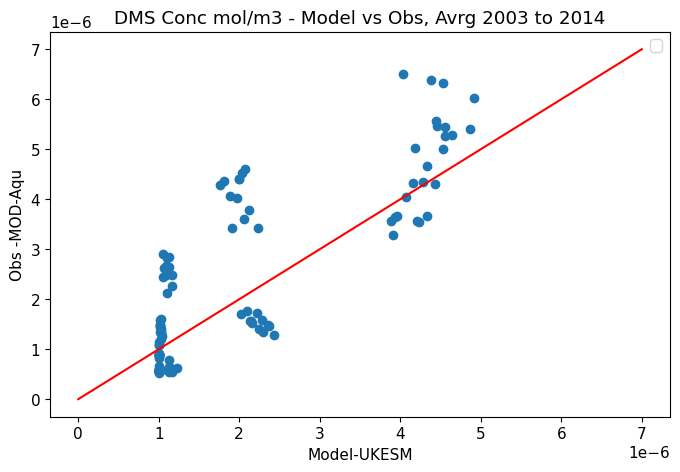

In [134]:
mpl.rcParams.update({'font.size':11})
fig, ax = plt.subplots(1,figsize=(8,5))
plt.plot(dms_AreaMean2003to2014_UKESM_GL,dmsObs_mthlymean*1e-6, 'o')
plt.plot([0,7e-6], [0,7e-6], 'k', color='red')
plt.xlabel('Model-UKESM')
plt.ylabel('Obs -MOD-Aqu')
plt.title('DMS Conc mol/m3 - Model vs Obs, Avrg 2003 to 2014')
plt.legend()
plt.savefig('DMS_SurfConc_correlation_UKESM_vs_ObsModisAqua.png')

In [132]:
dms_2003to2014_UKESM_GL

<xarray.DataArray 'dmsos' (time: 144, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 2003-01-16 00:00:00 ... 2014-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

In [77]:
## 2- first 30 years
dms_1850to1880_UKESM_GL = dmsosset_UKESM_GLarea.isel(time = slice(372)).compute() 
dms_1850to1880_UKESM_GL

<xarray.DataArray 'dmsos' (time: 372, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1880-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

In [78]:
## 2- first 30 years
dms_1850to1880_UKESM_GL = dmsosset_UKESM_GLarea.isel(time = slice(372)).compute() #.compute does the excution of the mean operation
dms_1850to1880_UKESM_GL

<xarray.DataArray 'dmsos' (time: 372, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1880-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

In [79]:
## 2- first 30 years
dms_1850to1880_UKESM_GL = dmsosset_UKESM_GLarea.isel(time = slice(372)).compute() #.compute does the excution of the mean operation
dms_1850to1880_UKESM_GL

<xarray.DataArray 'dmsos' (time: 372, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1880-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

In [80]:
## 2- first 30 years
dms_1850to1880_UKESM_GL = dmsosset_UKESM_GLarea.isel(time = slice(372)).compute() #.compute does the excution of the mean operation
dms_1850to1880_UKESM_GL

<xarray.DataArray 'dmsos' (time: 372, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 1850-01-16 00:00:00 ... 1880-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

In [81]:
## 3- last 30 years
dms_1984to2014_UKESM_GL = dmsosset_UKESM_GLarea.isel(time = slice(1608,None)).compute() #.compute does the excution of the mean operation
dms_1984to2014_UKESM_GL

<xarray.DataArray 'dmsos' (time: 372, j: 46, i: 25)>
array([[[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
...
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]],

       [[   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        [   nan,    nan,    nan, ...,    nan,    nan,    nan],
        ...,
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [1.e-06, 1.e-06, 1.e-06, ...,    nan,    nan,    nan],
        [   nan,    nan, 1.e-06, ...,    nan,    nan,    nan]]],
      dtype=float32)
Coordinates:
  * time       (time) object 1984-01-16 00:00:00 ... 2014-12-16 00:00:00
  * j          (j) int32 274 275 276 277 278 279 280 ... 314 315 316 317 318 319
  * i          (i) int32 267 268 269 270 271 272 273 ... 286 287 288 289 290 291
    latitude   (j, i) float32 60.85 60.82 60.77 60.73 ... 78.01 77.59 77.17
    longitude  (j, i) float32 -18.25 -17.08 -15.91 -14.74 ... 49.82 50.68 51.49

## close for now

<xarray.DataArray (month: 12)>
array([2.8692844e-07, 3.3930135e-07, 9.1022622e-07, 2.6846690e-06,
       3.9303745e-06, 2.6842674e-06, 2.3568157e-06, 2.1230023e-06,
       1.8380975e-06, 1.3918835e-06, 7.2163789e-07, 3.9253345e-07],
      dtype=float32)
Coordinates:
    lev        float64 0.5058
    member_id  <U8 'r1i1p1f2'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

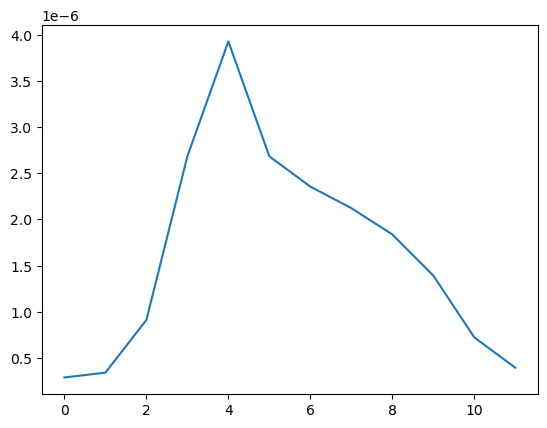

In [82]:
plt.plot(dms_2003to2014_AreaMean_MonthlyMean_GL)

dms_2003to2014_AreaMean_MonthlyMean_GL

### comparing CNRM averages with observation for the same period 2003 to 2014

In [83]:
dmsObs_2003to2014_GL

<xarray.Dataset>
Dimensions:      (pixel: 2386, time: 552)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2014-12-27
    year         (time) float64 2.003e+03 2.003e+03 ... 2.014e+03 2.014e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel, time) float64 -9.54 -9.54 -9.54 ... 8.372 8.372 8.372
    latitude     (pixel, time) float64 60.12 60.12 60.12 ... 84.88 84.88 84.88
    startjulday  (time, pixel) float64 1.0 1.0 1.0 1.0 ... 361.0 361.0 361.0
    endjulday    (time, pixel) float64 8.0 8.0 8.0 8.0 ... 365.0 365.0 365.0
    dms          (pixel, time) float64 nan nan nan nan ... nan nan nan nan

## Notes for the report and future projects
- try to install conda and jupyter locally on my laptop
- try to look at lynda that is a tool to access esfg (CMIP6) through conda
- cosp tool, which is a simulator for the cloud data to compare with modeling. COSP is included in the CMIP6 output
- save the codes